In [1]:
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import nltk 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk.corpus 
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
import re
import regex
import names



In [2]:
def dateTime(s):
    temp=s.split('-')
    temp1=temp[0].split(',')
    if(len(temp1)!=2):
            return False
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
def find_author(s):
    s = s.split(":")
#     print(s)
    if len(s)>=2:
        return True
    else:
        return False

In [4]:
def get_date_time_auther_msg(line):   
    splitline = line.split(' - ')
    date_Time = splitline[0]
    date, time = date_Time.split(", ")
    message = " ".join(splitline[1:])
    
    if(find_author(message)):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

In [5]:
#organising text data

In [6]:
data = []

conversation=r"C:\Nandini\ml_projects\projects\Natrual language processing\whatsapp data analysis\WhatsApp Chat with Bitches forever.txt"
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if dateTime(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = get_date_time_auther_msg(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [7]:

df = pd.DataFrame(data, columns=["Date", 'Time', 'Author', 'Message'])


In [8]:
m,n=df.shape

In [9]:
df.head()

Date   Time   Author                             Message
0  13/02/2020  20:55     None  Ujwala created group "chutti gang"
1  13/02/2020  20:55     None                      You were added
2  10/08/2020  09:54  Tanmaya       Guy's aaj thoda late ho jaega
3  10/08/2020  09:56  Nandini                                   K
4  10/08/2020  09:56  Nandini                                  Np

In [10]:
media_messages=df[df.Message=='<Media omitted>']
df1=df.dropna()
df1=df1[df1.Message!='<Media omitted>']
df1=df1[df1.Message!='You have deleted this message']
df1=df1[df1.Message!='This message was deleted']


In [11]:
par=list(df1.Author.unique())
rand_name=[]
for i in range(len(par)):
    rand_name.append(names.get_first_name(gender='female'))
df1['Author'].replace(par, rand_name, inplace=True)
df1.head()

Date   Time  Author  \
2  10/08/2020  09:54  Judith   
3  10/08/2020  09:56     Kim   
4  10/08/2020  09:56     Kim   
5  10/08/2020  10:01    Joan   
6  10/08/2020  10:05  Judith   

                                             Message  
2                      Guy's aaj thoda late ho jaega  
3                                                  K  
4                                                 Np  
5                                              Okayy  
6  Tanmaya M. is inviting you to a scheduled Zoom...

In [12]:
# replacing the names in messages 
for(name,alias) in zip(par, rand_name):
    df1.Message = df1.Message.str.replace(name,alias)


In [13]:
df1["Date"]=df1["Date"]+' '+df1["Time"]
df1["Date"] = pd.to_datetime(df1["Date"],dayfirst=True)

In [14]:
df1.head()

Date   Time  Author  \
2 2020-08-10 09:54:00  09:54  Judith   
3 2020-08-10 09:56:00  09:56     Kim   
4 2020-08-10 09:56:00  09:56     Kim   
5 2020-08-10 10:01:00  10:01    Joan   
6 2020-08-10 10:05:00  10:05  Judith   

                                             Message  
2                      Guy's aaj thoda late ho jaega  
3                                                  K  
4                                                 Np  
5                                              Okayy  
6  Judith M. is inviting you to a scheduled Zoom ...

In [15]:
#adding new columns 
df1['weekday'] = df1['Date'].apply(lambda x: x.day_name())
df1['month_sent'] = df1['Date'].apply(lambda x: x.month_name())
df1['hour'] = [d.time().hour for d in df1['Date']]

In [16]:
URLPATTERN = r'(https?://\S+)'
df1['urlcount'] = df1.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
#column Letter_Count
df1['Letter_Count'] = df1['Message'].apply(lambda s : len(s))
#column Word_Count
df1['Word_Count'] = df1['Message'].apply(lambda s : len(s.split(' ')))

In [17]:
df1["Date"]= pd.to_datetime(df1['Date']).dt.date

In [18]:
df1.head()


Date   Time  Author  \
2  2020-08-10  09:54  Judith   
3  2020-08-10  09:56     Kim   
4  2020-08-10  09:56     Kim   
5  2020-08-10  10:01    Joan   
6  2020-08-10  10:05  Judith   

                                             Message weekday month_sent  hour  \
2                      Guy's aaj thoda late ho jaega  Monday     August     9   
3                                                  K  Monday     August     9   
4                                                 Np  Monday     August     9   
5                                              Okayy  Monday     August    10   
6  Judith M. is inviting you to a scheduled Zoom ...  Monday     August    10   

   urlcount  Letter_Count  Word_Count  
2         0            29           6  
3         0             1           1  
4         0             2           1  
5         0             5           1  
6         1           261          35

In [19]:
def emoji_count(text):
    emoji_list = []
    data = regex.findall(r'\X',text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    return emoji_list
df1['emoji'] = df1["Message"].apply(emoji_count)


In [20]:
df1.head()

Date   Time  Author  \
2  2020-08-10  09:54  Judith   
3  2020-08-10  09:56     Kim   
4  2020-08-10  09:56     Kim   
5  2020-08-10  10:01    Joan   
6  2020-08-10  10:05  Judith   

                                             Message weekday month_sent  hour  \
2                      Guy's aaj thoda late ho jaega  Monday     August     9   
3                                                  K  Monday     August     9   
4                                                 Np  Monday     August     9   
5                                              Okayy  Monday     August    10   
6  Judith M. is inviting you to a scheduled Zoom ...  Monday     August    10   

   urlcount  Letter_Count  Word_Count   emoji  
2         0            29           6      []  
3         0             1           1      []  
4         0             2           1      []  
5         0             5           1      []  
6         1           261          35  [✨, ✨]

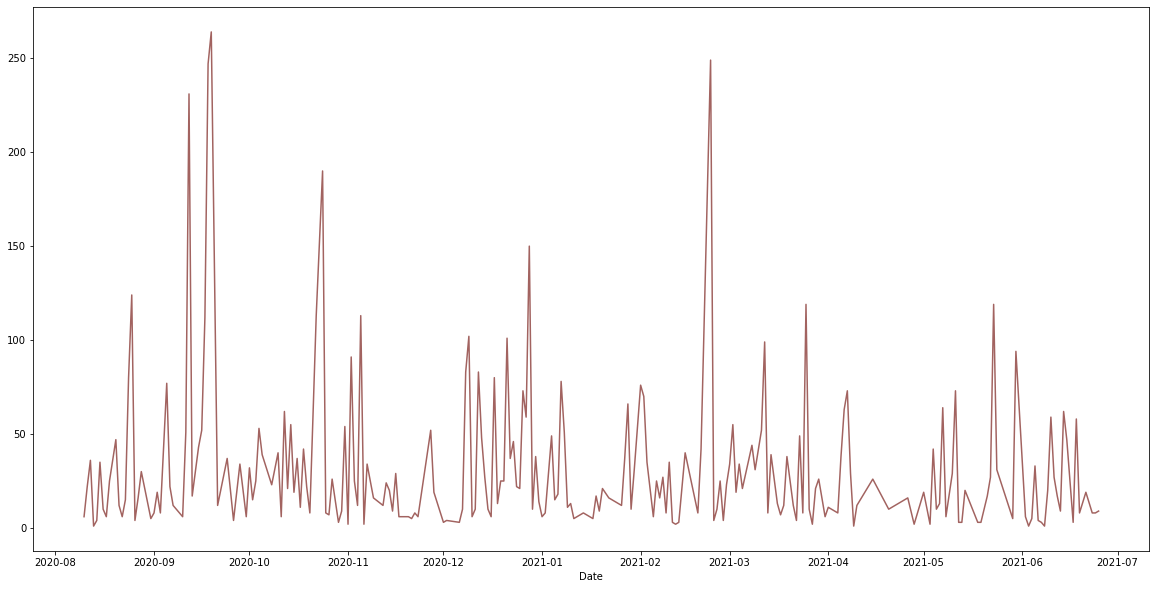

In [21]:
date_grouped = df1.groupby('Date')['Message'].count().plot(kind='line', figsize=(20,10), color='#A26360')

In [22]:
weekday_grouped_msg =  (df1.set_index('weekday')['Message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
weekday_grouped_msg

fig = px.line_polar(weekday_grouped_msg, r='count', theta='weekday', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

In [23]:
hour_grouped_msg =  (df1.set_index('hour')['Message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
fig = px.bar(hour_grouped_msg, x='hour', y='count',
                 labels={'hour':'24 Hour Period'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Total Messages by Hour of the Day')
fig.show()

In [24]:
total_messages = df1.shape[0]
mms=media_messages.shape[0]
average_message_words = df1['Word_Count'].mean()
average_message_letters = df1['Letter_Count'].mean()
average_message_day = df1.groupby('Date')['Message'].count().mean()
print('Total Messages ',total_messages)
print('Media Message', mms)
print('Average Words by Messages', round(average_message_words, 2))
print('Average Letters by Messages', round(average_message_letters, 2))
print('Average Message Per Day', round(average_message_day, 2))

Total Messages  7552
Media Message 727
Average Words by Messages 6.89
Average Letters by Messages 34.69
Average Message Per Day 32.14


Kim       3389
Judith    2185
Joan      1978
Name: Author, dtype: int64

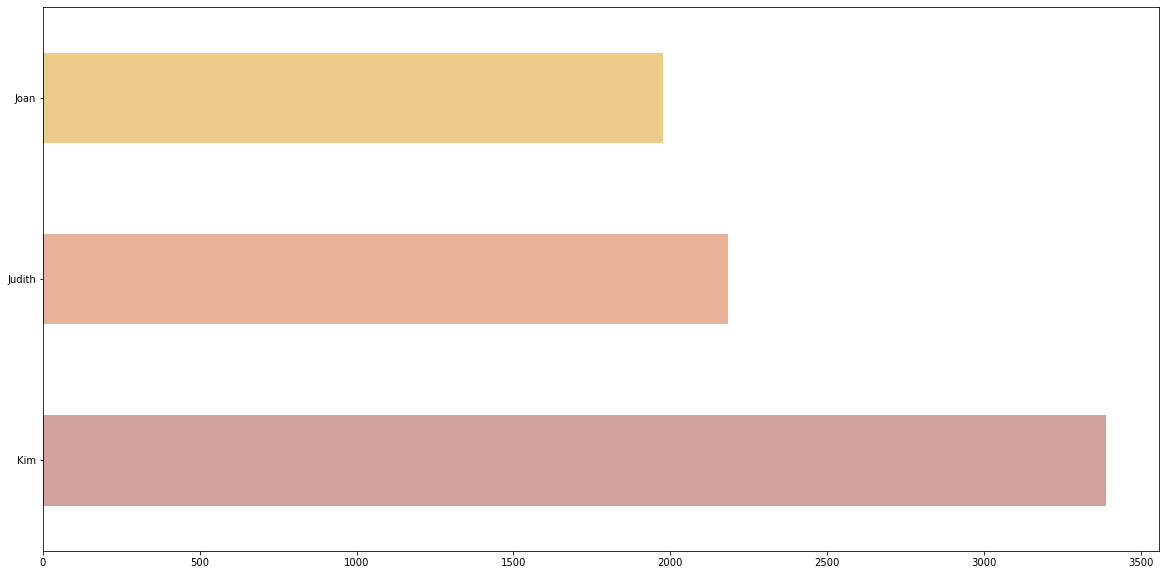

In [25]:
qty_message_author = df1['Author'].value_counts()

qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
qty_message_author

In [26]:
from datetime import date
def find_no_days(date1,date2):
    d1=date1.split('/')
    d2=date2.split('/')
    dt1 = date(int(d1[2]),int(d1[1]) ,int(d1[0]))
    dt2 = date(int(d2[2]),int(d2[1]) ,int(d2[0]))
    delta=dt2-dt1
    return delta.days

Kim       10.623824
Judith     6.849530
Joan       6.200627
Name: Author, dtype: float64

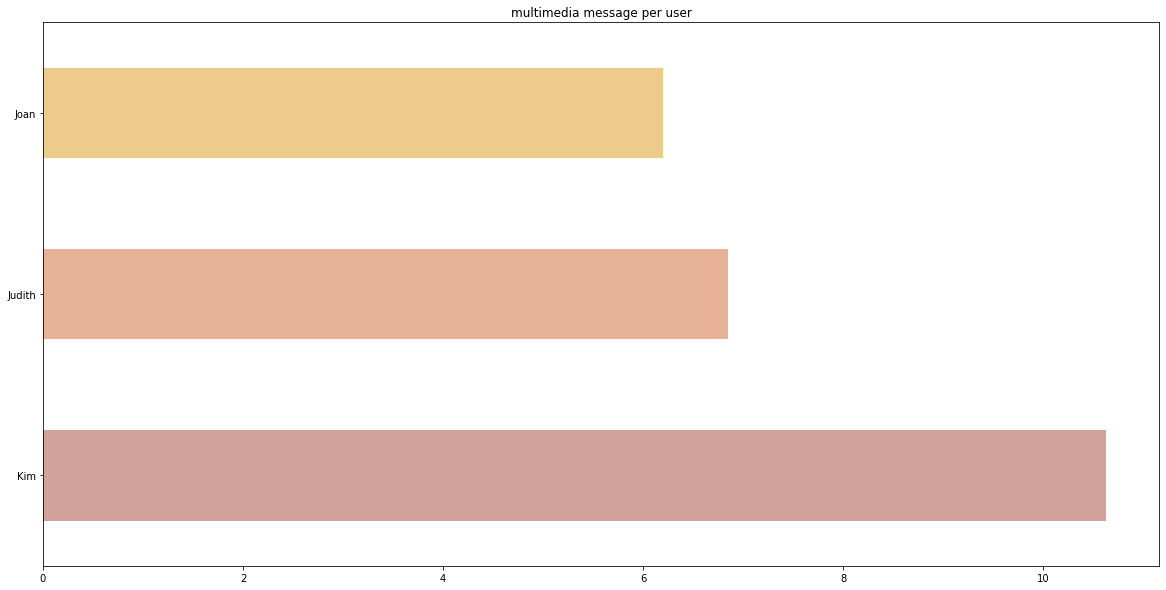

In [27]:

j=0
for i in df["Author"]:
    if(i!=None):
        break
    j+=1
d0=df.iloc[j,0]
d1=df.iloc[-1,0]
qty_message_author_avg=df1['Author'].value_counts()
qty_message_author_avg=qty_message_author_avg/find_no_days(d0,d1)
ax=qty_message_author_avg.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
ax.set_title('multimedia message per user')
qty_message_author_avg


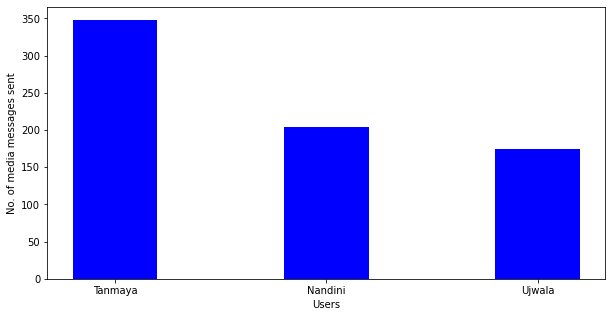

In [28]:
uniau=list(media_messages.Author.unique())
hs=dict()
for i in uniau:
    temp=media_messages[media_messages.Author==i].shape[0]
    hs[i]=temp
x_axis=list(hs.keys())
y_axis=list(hs.values())
dfmms=pd.DataFrame.from_dict({'Author':x_axis,'media_messages':y_axis})
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(x_axis, y_axis, color ='blue',
        width = 0.4)
 
plt.xlabel("Users")
plt.ylabel("No. of media messages sent")
plt.show()

Kim       4.487553
Judith    2.893273
Joan      2.619174
Name: Author, dtype: float64

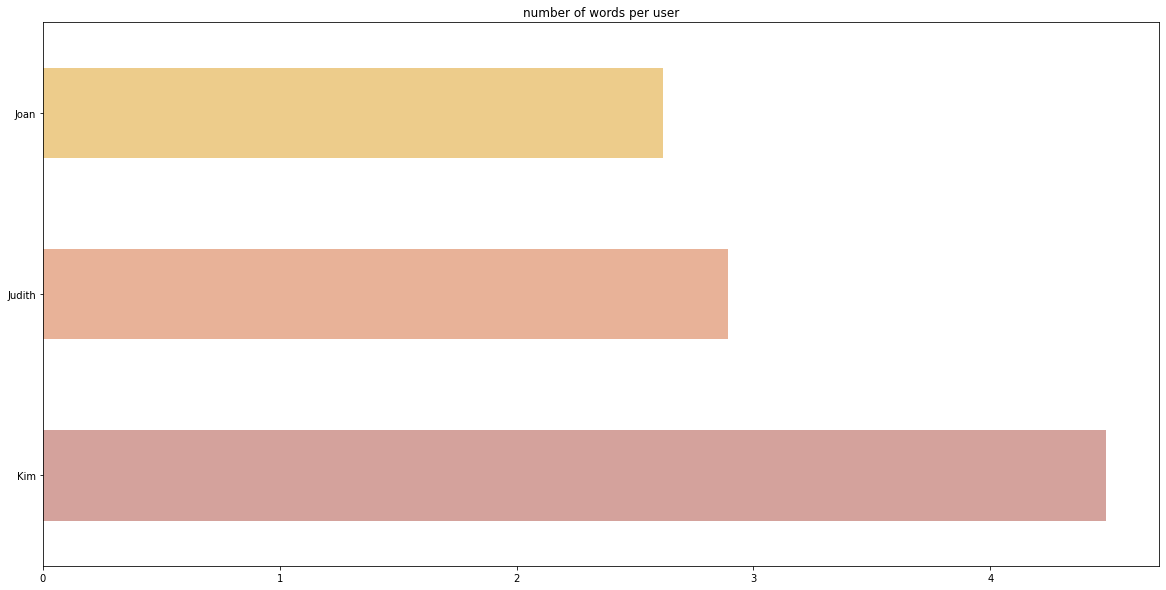

In [29]:
# number of words per user:
no_words_per_user=qty_message_author/df1.shape[0]
no_words_per_user=no_words_per_user*10
ax=no_words_per_user.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
ax.set_title('number of words per user')
no_words_per_user

Text(0.5, 1.0, 'number of emojis per user')

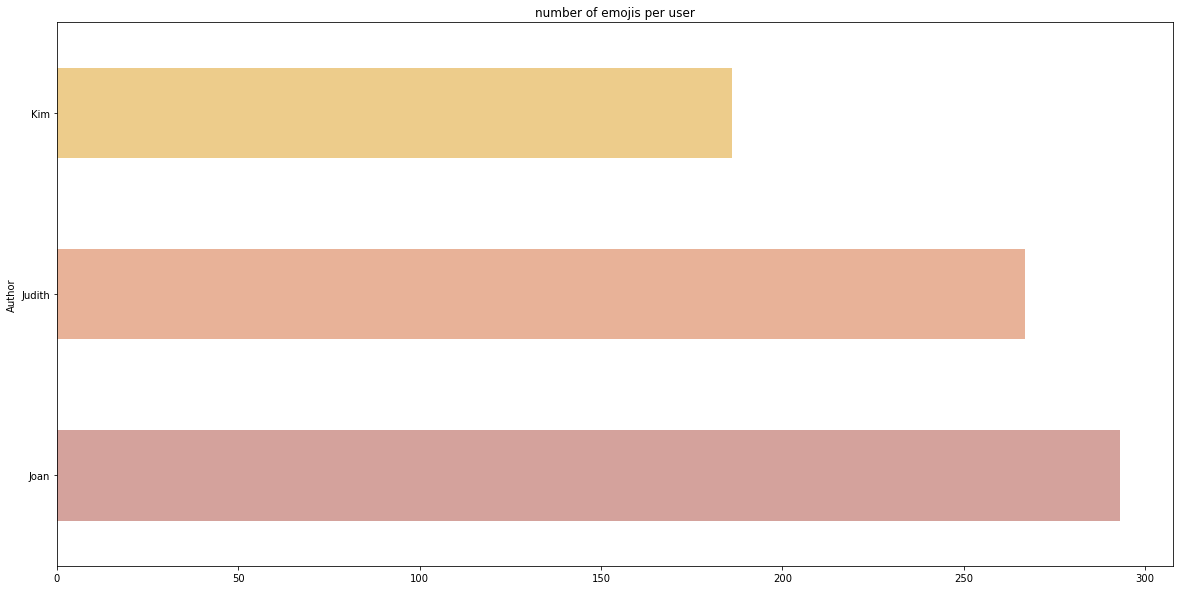

In [30]:
dfemoji=pd.DataFrame()
dfemoji['Author']=(df1['Author'])
dfemoji["emoji"]=(df1['emoji'])
dfemoji=dfemoji[dfemoji['emoji'].str.len()!=0]
count=list()
for x in dfemoji['emoji']:
    count.append(len(x))
dfemoji["total"]=count
dfemo=dfemoji.groupby(['Author']).total.sum()
ax=dfemo.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
ax.set_title('number of emojis per user')

Text(0.5, 1.0, 'number of urls per user')

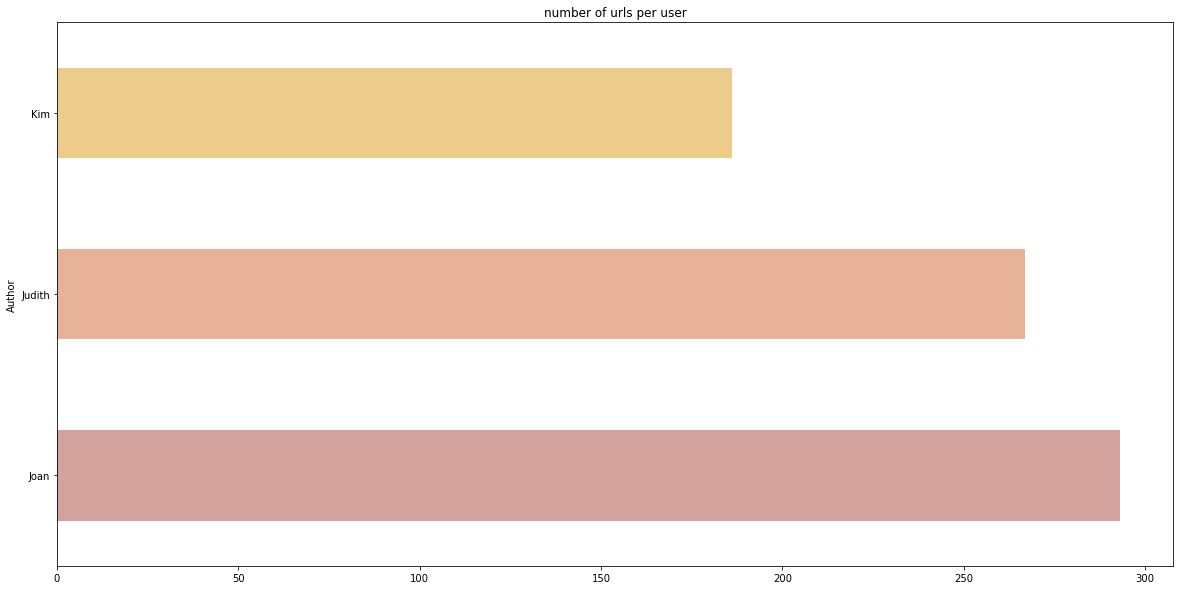

In [31]:
dfurl=df1.groupby('Author').urlcount.sum()
dfurl
ax=dfemo.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])

ax.set_title('number of urls per user')

In [32]:
total_emojis_list = list([a for b in df1.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])


In [33]:
fig = px.treemap(emoji_df, path= ['emoji'],
    values = emoji_df['count'].tolist(),
)
fig.show()

common words in the chat


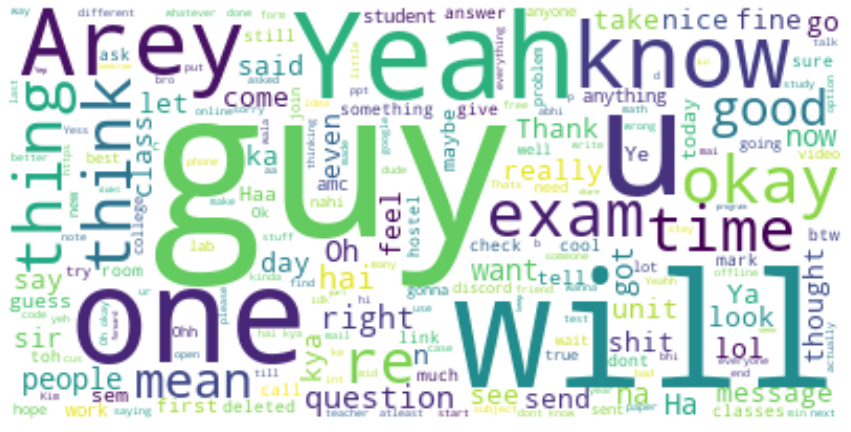

In [34]:

text = " ".join(review for review in df1.Message)
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
print("common words in the chat")
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Judith


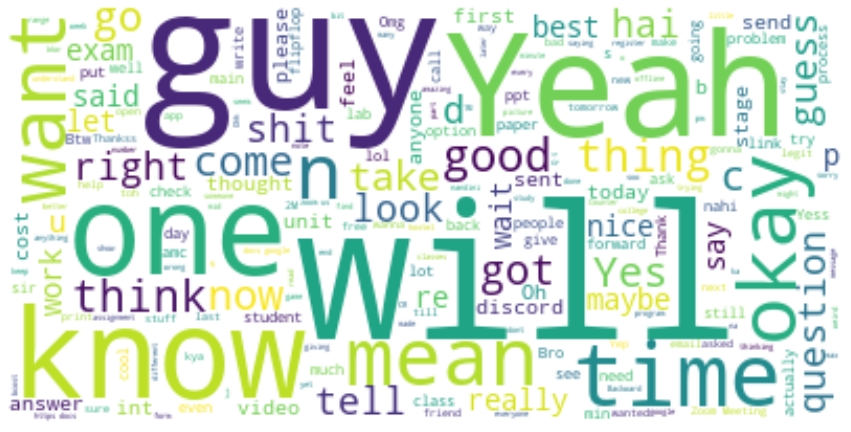

Author name Kim


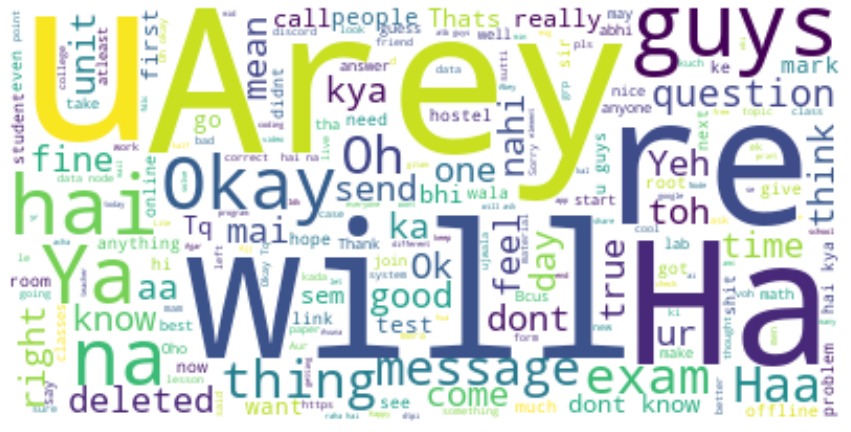

Author name Joan


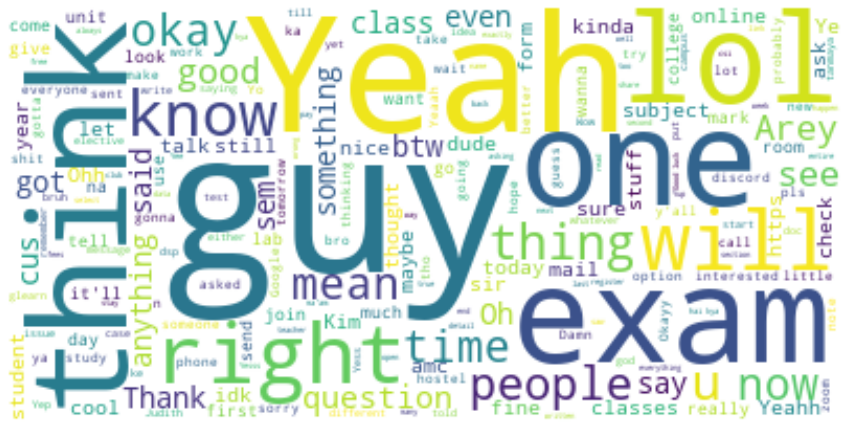

In [35]:
# individual word clouds
l = list(df1.Author.unique())
for i in range(len(l)):
      dummy_df = df1[df1['Author'] == l[i]]
      text = " ".join(review for review in dummy_df.Message)
      stopwords = set(STOPWORDS)
      #Generate a word cloud image
      print('Author name',l[i])
      wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
      #Display the generated image   
      plt.figure( figsize=(15,10))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis("off")
      plt.show()